In [1]:
# %load_ext autoreload 
# %autoreload 2

import sys
import json
import re
import pandas as pd
import pickle
from numpy.testing import assert_allclose
from pathlib import Path

from dask.distributed import Client
from sklearn import set_config
from macro_utils import load_datastore
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

# internal
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")
sys.path.append(r"C:\ami")
sys.path.append(r"C:\SyMAWoFlo\Symawofo")

In [2]:
from symawofo import FeatureFrame, DataSplitter, WindowFrame, get_client
client = get_client(0)


c:\environments\symawofo\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61865 instead
  warnings.warn(


In [3]:
from ami.run.macrobot import MacrobotRunner

asset = 'US_Equity_Fut'
runner = MacrobotRunner(asset)


In [ ]:
runner.get_source_into_next_cell()

In [17]:
from ami.build.loss import get_loss_fn
from ami.macrobot.jobspec import Jobspec
from symawofo.ensemble import BaggingRegressor, FeatureEnsemble
from symawofo.transformers import (Clipper, Difference, Lag, make_column_transformer,
                                   make_pipeline,
                                   StandardScaler, TransformedTargetRegressor)
from symawofo import FeatureFrame, DataSplitter, WindowFrame
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.pnl import PNL, AssetType
from macro_utils import DotDict
from ami.build.common import (make_pca_column_transformer, make_pca_diff_column_transformer,
    make_local_data_passthrough)
from ami.macrobot.models import GRURegressor, CNNRegressor
from ami.build.loss import SampleWeightDecay


#%%
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

#%% [markdown]
## Feature transformation and Embeded models


#%% 

def make_preprocessing(target, prediction_lag):
    target_prepipeline = make_pipeline(
            Difference(),
            Lag(-prediction_lag)
    )
    return target_prepipeline.fit_transform(target)


def make_feature_transform(config: DotDict):
    tr_pca_levels = make_pca_column_transformer(config.PCA)
    tr_pca_diffs = make_pca_diff_column_transformer(config.PCA_diff)
    tr_level_features = [('passthrough', config.pass_through)]
    tr_diffs = [(Difference(1), config.diff)]
    tr_local = make_local_data_passthrough(config)

    ct = tr_pca_levels + tr_pca_diffs + tr_level_features + tr_diffs + tr_local

    return make_pipeline(
            make_column_transformer(*ct, remainder='drop'),
            StandardScaler(),
            Clipper(-config.clip_level, config.clip_level)
    )


def make_model(**kwargs):
    kwargs['loss'] = get_loss_fn(kwargs['loss'])
    sample_weights_fn = SampleWeightDecay(kwargs.get('decay')) if kwargs.get('decay') else None
    if kwargs.pop('type') == 'GruModel':
        return GRURegressor(_sample_weight_fn=sample_weights_fn, **kwargs)
    else:
        return CNNRegressor(_sample_weight_fn=sample_weights_fn, **kwargs)


def get_feature_callable(features, group=False, ignore_pca=True):
    def feature_callable(X):
        results = []
        pca_features = X.filter_by_ancestors_names(list(X.features.query(f"transformer_name=='PCA'").index))

        for f in features:
            temp = X.filter_by_ancestors_names(f)

            if ignore_pca and '_PCA' not in f:
                temp = [i for i in temp if i not in pca_features]

            if len(temp) == 1 or group == 'separate':
                results += temp
            else:
                assert group, f"Feature had multiple children, choose from following:\n " + ','.join(temp)
                if group == 'combine':
                    results.append(tuple(temp))
                else:
                    assert False, "group should be False, 'combined' or 'separate'"
        results_ex_dups = [*dict.fromkeys(results)]
        results_keys = [str(i) if isinstance(i, tuple) else i for i in results_ex_dups]
        results_dict = dict(zip(results_keys, results_ex_dups))
        return results_dict

    return feature_callable



def get_FeatureEnsemble_params(spec):
    testing_features = spec.pop('features')
    feature_type = spec.pop('type')
    group = spec.pop('group')
    ignore_pca = spec.pop('ignore_pca')

    faulty_cond = (feature_type == ('core_features') and (group == 'combine'))
    warning = "feature_testing parameter 'group' cannot be 'combine' if feature_type is 'core_features' \nSet 'group' to 'separate' or False"
    assert not faulty_cond, warning
    if testing_features:
        features_callable = get_feature_callable(testing_features, group=group, ignore_pca=ignore_pca)
        spec[feature_type] = features_callable
    return spec


def make_ensemble_model(jobspec: DotDict):
    model = make_model(**jobspec.model)
    feature_transform = make_feature_transform(jobspec.features_transform)

    if ensemble := dict(jobspec.ensemble):
        if ensemble.pop('type') == 'bagging':
            model = BaggingRegressor(model, **ensemble)

    if feature_testing := jobspec.get('feature_testing', None):
        feature_params = get_FeatureEnsemble_params(dict(feature_testing))
        model = FeatureEnsemble(model, **feature_params)

    estimator = make_pipeline(
        feature_transform,
        model
    )
    target_postpipline = make_pipeline(
        StandardScaler(with_mean=jobspec.target_transform.with_mean),
        Clipper(-jobspec.target.clip_level, jobspec.target.clip_level))
    return TransformedTargetRegressor(estimator, target_postpipline)


def make_data_splitter(jobspec: DotDict):
    return  DataSplitter(
            **jobspec.data_splitter,
            drop_remaining=True,
            last_training_window=True
    )


def make_window_frame(jobspec: DotDict, data):
    target = data[jobspec.target.name]
    modeling_features = FeatureFrame(data=data)
    modeling_target = make_preprocessing(target, jobspec.target.prediction_lag)
    splitter = make_data_splitter(jobspec)
    targetRegressor = make_ensemble_model(jobspec)
    wf = WindowFrame(
            features=modeling_features,
            target=modeling_target,
            splitter=splitter,
            estimator=targetRegressor,
            parallel=True
    )
    return wf

def make_signal(jobspec: DotDict, window_frame:WindowFrame):
    return ThresholdSignSignal(window_frame, **jobspec.signal)

def make_pnl(jobspec: DotDict, signal):
    return PNL(signal,
        asset_type=AssetType(log=True, level=False),
        **jobspec.trade)

#%% [markdown]
## Main execution flow


def main():
    # %% [markdown]
    ###  prepare the job spec and fetch the dta

    # %%
    from ami.run.macrobot import MacrobotRunner
    spec = Jobspec({
    "data_splitter": {
        "expanding": 1,
        "initial_training_size": 375,
        "test_size": 52
    },
    "ensemble": {
        "agg_fn": None,
        "max_samples": 0.9,
        "n_estimators": 2,
        "type": "bagging"
    },
    "features_transform": {
        "PCA": [
            "US_ConsConf"
        ],
        "PCA_diff": [
            "US_Growth",
            "US_ConsConf",
            "US_Inflation",
            "US_Credit_Growth",
            "US_Inflexp",
            "US_FCI",
            "US_Risk",
            "US_WageExp"
        ],
        "clip_level": 8,
        "diff": [
            "GLOB_Equity",
            "US_Breakeven55",
            "US_Bond_10y",
            "US_erp_est",
            "US_AAII_Net",
            "US_CECI",
            "US_eps_upgrade_ratio"
        ],
        "pass_through": [
            "eq_per_flows_USA",
            "eq_ctry2_UnitedStates50_20",
            "US_AAII_Net",
            "US_CFTC_SPX",
            "US_erp_est",
            "US_GSInn",
            "US_Fiscal_Bal",
            "GLOB_CB_Bal",
            "US_CB_Bal",
            "US_2y_v_OIS",
            "US_ForYieldSp",
            "GLOB_EM_HCSp",
            "US_Buybacks_SPX_BBG",
            "US_MA_BBG",
            "GLOB_Equity_Skew",
            "US_Equity_Fut_Chg13",
            "US_Equity_Fut_Chg4",
            "US_CECI",
            "US_eps_upgrade_ratio",
            "ES_Volume_MA",
            "US_Equity_Fut_MASignal",
            "US_Equity_Fut_RSI",
            "US_EqBond_Corr_Ch",
            "US_EqBond_Corr",
            "US_PE",
            "US_Equity_Feature_2"
        ]
    },
    "model": {
        "activation": "selu",
        "batch_size": 1000,
        "batchnorm": True,
        "batchnorm_trainable": True,
        "batchnorm_training": False,
        "decay": 0.3,
        "dropout": 0.05,
        "epochs": 75,
        "lookback_periods": 13,
        "loss": "mse",
        "nodes": 15,
        "optimizer": "adam",
        "recurrent_dropout": 0.2,
        "regularizer_l1": 0.003,
        "regularizer_l2": 0.0,
        "type": "GruModel",
        "use_bias": False
    },
    "signal": {
        "c": 0.1,
        "threshold": None
    },
    "target": {
        "clip_level": 3,
        "name": "US_Equity_Fut",
        "prediction_lag": 1
    },
    "target_transform": {
        "type": "StandardScaler",
        "with_mean": False
    },
    "trade": {
        "t_cost": 0.0001
    }
})


    runner = globals().get('runner', MacrobotRunner(spec))
    data = runner.get_data()

    # %% [markdown]
    ###  build the model

    # %%
    wf = make_window_frame(spec, data)
    signal = make_signal(spec, wf)
    pnl = make_pnl(spec, signal)
#     pnl.get_pnl()

    # %%
    return pnl


In [18]:
pnl = main()
pnl.get_pnl()

Monitor progress at http://127.0.0.1:61865/status


distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Monitor progress at http://127.0.0.1:61865/status


distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


US_Equity_Fut_Difference1_Lead1_pred_0  \
2012-12-07                                1.000000   
2012-12-14                                0.999194   
2012-12-21                                1.011151   
2012-12-28                                0.982127   
2013-01-04                                1.036860   
...                                            ...   
2020-10-23                                1.728285   
2020-10-30                                1.675551   
2020-11-06                                1.750515   
2020-11-13                                1.773996   
2020-11-20                                1.766279   

            US_Equity_Fut_Difference1_Lead1_pred_1  
2012-12-07                                1.000000  
2012-12-14                                0.999194  
2012-12-21                                1.011151  
2012-12-28                                0.982127  
2013-01-04                                1.036860  
...                                            ...  
2020-10-23                                2.006243  
2020-10-30                                1.953509  
2020-11-06                                2.028473  
2020-11-13                                2.051954  
2020-11-20                                2.044236  

[416 rows x 2 columns]

In [19]:


# def quick_pnl(signal, target, asset_type=AssetType(log=True, level=False), t_cost=0.0001, **kwargs):
#     return PNL(signal, asset=target, asset_type=asset_type, t_cost=t_cost, **kwargs)

# def chart_runs(pnl):
#     predictions = pnl.signal.get_predictions()
#     signals = pnl.signal.signals
#     target = pnl.signal.wf.target.data
#     hold_signal = pred.ThresholdSignSignal(target=target, predictions=pd.Series(1, index=signals.index), threshold=0)
#     hold_pnl = quick_pnl(hold_signal, target).get_pnl()
    
#     ax1 = pnl.get_pnl().plot(figsize=(15, 10), color='grey', legend=False, alpha=0.5)
#     hold_pnl.plot(ax=ax1, color='blue', legend=False)
#     return ax1


# def chart_signals(signal, spec):
#     try:
#         t_cost = spec.trade.t_cost
#     except:
#         t_cost = 0
        
#     predictions = signal.get_predictions()
#     signals = signal.signals
#     target = signal.wf.target.data
#     hold_signal = pred.ThresholdSignSignal(target=target, predictions=pd.Series(1, index=signals.index), threshold=0)
#     hold_pnl = quick_pnl(hold_signal, target, t_cost=t_cost).get_pnl()
    
#     avg_pred_signal = pred.AvgThresholdSignSignal(target, predictions, **spec.signal)
#     avg_pred_pnl = quick_pnl(avg_pred_signal, target, t_cost=t_cost).get_pnl()
    
#     med_pred_signal = pred.MedianThresholdSignSignal(target, predictions, **spec.signal)
#     med_pred_pnl = quick_pnl(med_pred_signal, target, t_cost=t_cost).get_pnl()
    
#     avg_sign_signal = pred.AvgIdentitySignSignal(target, signals)
#     avg_sign_pnl = quick_pnl(avg_sign_signal, target, t_cost=t_cost).get_pnl()
    
#     med_sign_signal = pred.MedianIdentitySignSignal(target, signals)
#     med_sign_pnl = quick_pnl(med_sign_signal, target, t_cost=t_cost).get_pnl()
    
#     ax = hold_pnl.plot(figsize=(15, 10))
#     avg_pred_pnl.plot()
#     med_pred_pnl.plot()
#     avg_sign_pnl.plot()
#     med_sign_pnl.plot()
#     ax.legend(['Asset', 'Avg_Pred', 'Med_Pred', 'Avg_Sig', 'Med_Sig'])
    
#     return ax

# def chart_scatter(signal):
#     predictions = signal.get_predictions().mean(axis=1)
#     target = signal.wf.target.data.reindex(predictions.index)
    
#     sns.set_style('ticks')
#     fig, ax = plt.subplots()
#     fig.set_size_inches(18.5, 10.5)
#     sns.regplot(predictions, target, ax=ax)
#     sns.despine()
#     plt.axvline(x=0, color='k')
#     plt.axhline(y=0, color='k')
#     return ax

# def collect_histories(wf):
#     results = dict()
#     for w in wf[:-1]:
#         train_loss = []
#         val_loss = []
#         for est in w.model.estimators_:
#             train_loss.append(pd.Series(est.history_['loss']))
#             val_loss.append(pd.Series(est.history_['val_loss']))

#         results[w.training_end] = pd.concat(train_loss, axis=1), pd.concat(val_loss, axis=1)
#     return results

# def chart_loss(loss_dict, date):
#     chart_loss_helper(*loss_dict[date], title=date.strftime('%Y-%m-%d'))

# def chart_loss_helper(training_loss, val_loss, title=None):
#     train_mean = training_loss.mean(axis=1)
#     train_min = training_loss.min(axis=1)
#     train_max = training_loss.max(axis=1)
    
#     val_mean = val_loss.mean(axis=1)
#     val_min = val_loss.min(axis=1)
#     val_max = val_loss.max(axis=1)
    
#     ax = train_mean.plot(figsize=(15,10), title=title)
#     val_mean.plot()
    
#     ax.fill_between(train_mean.index, train_min, train_max, facecolor='blue', alpha=0.2)
#     ax.fill_between(val_mean.index, val_min, val_max, facecolor='orange', alpha=0.2)
    
    
# def chart_by_threshold(signal, threshold):
#     threshold = float(threshold) if isinstance(threshold, str) else threshold
#     target = signal.wf.target.data
#     new_signal = pred.AvgThresholdSignSignal(target, signal.predictions, threshold=threshold)
#     pnl = PNL(new_signal, asset=signal.wf.target.data, asset_type=AssetType(log=True, level=False), t_cost=0.0001)
#     ax = pnl.get_pnl().plot(figsize=(15, 10))
    
#     hold_signal = pred.ThresholdSignSignal(target=target, predictions=pd.Series(1, index=signal.signals.index), threshold=0)
#     hold_pnl = quick_pnl(hold_signal, target).get_pnl()
#     hold_pnl.plot()
#     ax.legend(['Strategy', 'Asset'])

In [14]:
pnl.signal._predictions = pnl.signal._predictions*100

In [20]:
import ipywidgets as widgets
from ami.macrobot.charting_tools import *

<AxesSubplot:>

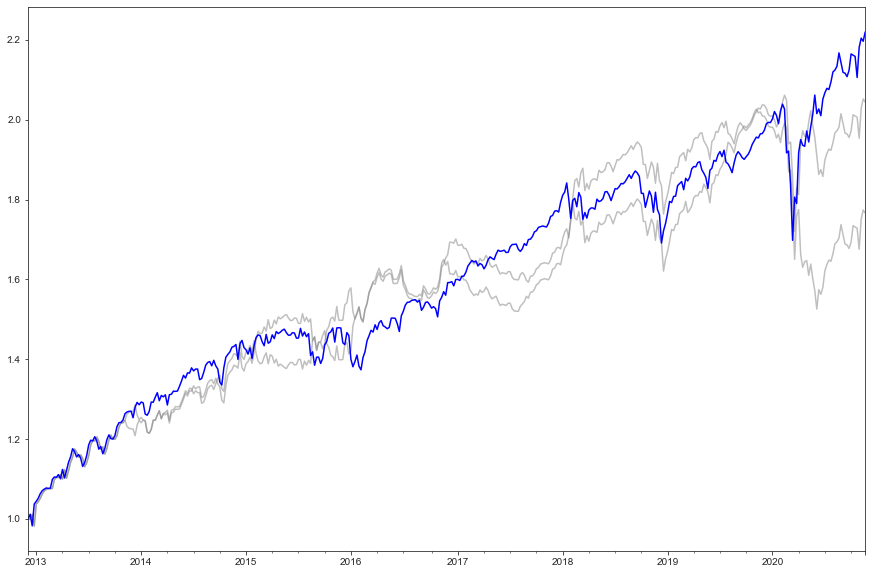

In [21]:
chart_runs(pnl)

<AxesSubplot:>

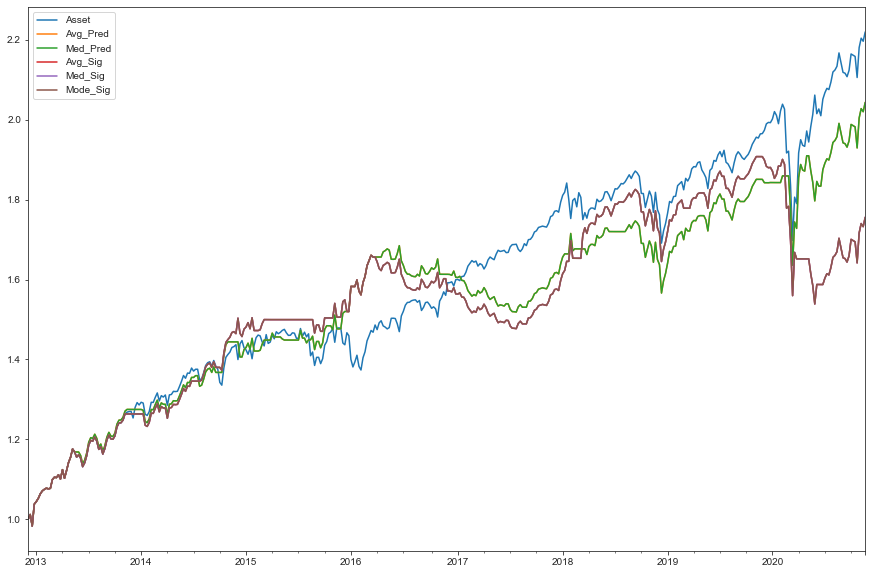

In [22]:
chart_signals(pnl.signal, runner.jobspec)

<AxesSubplot:ylabel='US_Equity_Fut_Difference1_Lead1'>

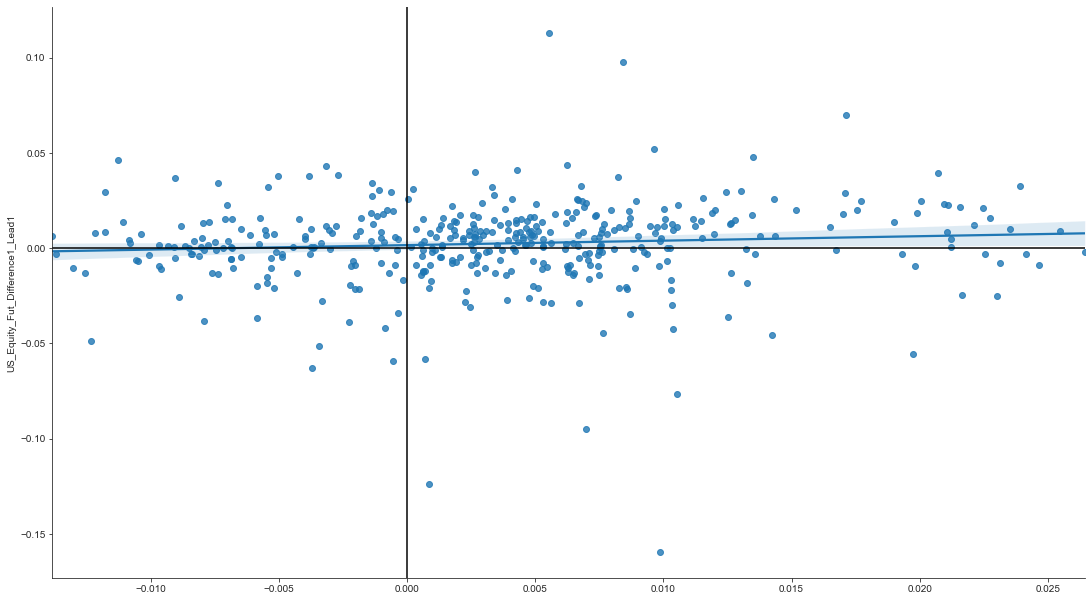

In [23]:
chart_scatter(pnl.signal)

In [24]:
dates = [w.training_end for w in pnl.signal.wf[:-1]]
results = collect_histories(pnl.signal.wf)
widgets.interactive(chart_loss, loss_dict=widgets.fixed(results), date=dates)

interactive(children=(Dropdown(description='date', options=(Timestamp('2012-11-30 00:00:00'), Timestamp('2013-…

In [25]:
widgets.interactive(chart_by_threshold, signal=widgets.fixed(pnl.signal), threshold='0.000')

interactive(children=(Text(value='0.000', description='threshold'), Output()), _dom_classes=('widget-interact'…